# Titanic Survival Prediction

## Objective
Predict whether a passenger survived the Titanic disaster using structured data. The goal is to practice end-to-end machine learning with preprocessing, feature engineering, and tree-based models, comparing single trees vs. ensemble methods.

## Dataset
- **Source:** Kaggle Titanic Dataset
- **Features:** `PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked`
- **Target:** `Survived` (0 = No, 1 = Yes)
- **Size:** 891 training samples

## Problem Definition
Binary classification task: predict `Survived`.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Data overview

In [2]:
# Load dataset
df = pd.read_csv('titanic.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


In [6]:
numeric_cols = df.select_dtypes('number').columns
categor_cols = df.select_dtypes('O').columns

In [7]:
for col in categor_cols:
    print(df[col].value_counts())
    print('------------------------------------------\n')

Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Hewlett, Mrs. (Mary D Kingcome)                        1
Vestrom, Miss. Hulda Amanda Adolfina                   1
Andersson, Mr. Anders Johan                            1
Saundercock, Mr. William Henry                         1
Bonnell, Miss. Elizabeth                               1
Name: count, Length: 891, dtype: int64
------------------------------------------

Sex
male      577
female    314
Name: count, dtype: int64
------------------------------------------

Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
PC 17590            1
17463               1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Preprocessing

In [9]:
data = df.copy()

### 1. Drop unuseful columns

In [10]:
data.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)

In [11]:
numeric_cols = data.select_dtypes('number').columns
categor_cols = data.select_dtypes('O').columns

In [12]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 2. Check **Duplicates**

In [13]:
data.duplicated().sum()

np.int64(111)

### 3. Check **Missing values**

In [14]:
data.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


#### Fill Missing values in **Embarked** by **Mode**

In [15]:
data['Embarked'].mode()

,Embarked
0,S


In [16]:
data['Embarked'].fillna('S', inplace=True)

/tmp/ipython-input-307638690.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna('S', inplace=True)


In [17]:
data['Age'].value_counts()

,count
Age,
24.00,30
22.00,27
18.00,26
28.00,25
30.00,25
...,...
24.50,1
0.67,1
0.42,1


In [18]:
data['Age'].median(), data['Age'].mean()

(28.0, np.float64(29.69911764705882))

#### Fill Missing values in **Age** by **KNN Imputation**

In [19]:
# use KNN Imputation
from sklearn.impute import KNNImputer

data_knn = data[numeric_cols].copy()

In [20]:
data_knn.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [21]:
# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=5)
data_knn_imputed = imputer.fit_transform(data_knn)

In [22]:
# Update the 'bmi' column in the original df
data['Age'] = data_knn_imputed[:, data_knn.columns.get_loc('Age')]

In [23]:
# data['Age'].fillna(data['Age'].median(), inplace=True)

#### Cnvert **Age** col by **integer** datatype

In [24]:
data['Age'] = data['Age'].astype(int)

In [25]:
data['Age'].value_counts()

,count
Age,
28,52
24,40
31,38
21,37
29,32
...,...
66,1
12,1
53,1


### 4. Check **Outliers**

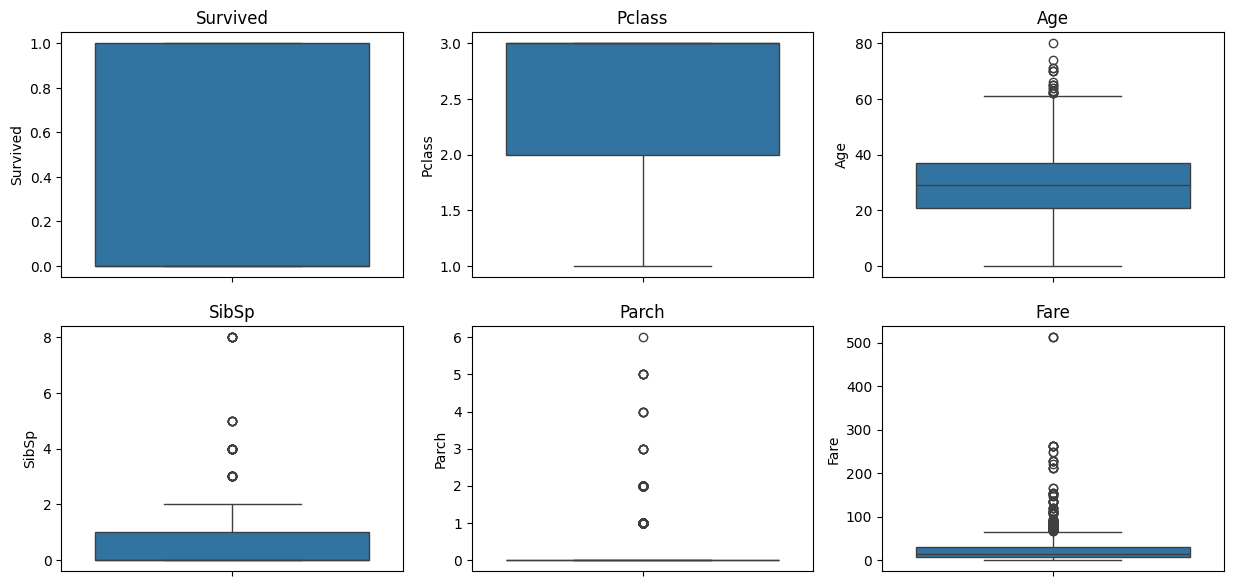

In [26]:
col_num = 3
row_num = 2

fig, axes = plt.subplots(nrows=row_num, ncols=col_num, figsize=(15,7))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=data, ax=axes[i], y=col)
    axes[i].set_title(col)

#### Handle outliers in the numeric columns by capping them with upper value

In [27]:
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    # data = data[data[col] <= upper]
    data[col] = data[col].clip(upper=upper)

##  Exploratory Data Analysis (EDA)

In [28]:
# manually adding annotations to each bar in Countplot
# Honstely i get this function from AI tool
def annotate_bars(ax):
    for p in ax.patches:
        count = int(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y + 1, str(count), ha='center', va='bottom')

### Distribution of Survival

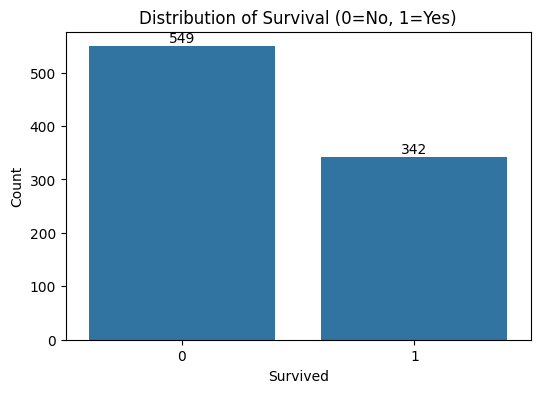

In [29]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=data, x='Survived')
plt.title('Distribution of Survival (0=No, 1=Yes)')
plt.xlabel('Survived')
plt.ylabel('Count')
annotate_bars(ax)
plt.show()

#### This show that this data is **unbalanced**

### Survival by Sex, Pclass, and Embarked

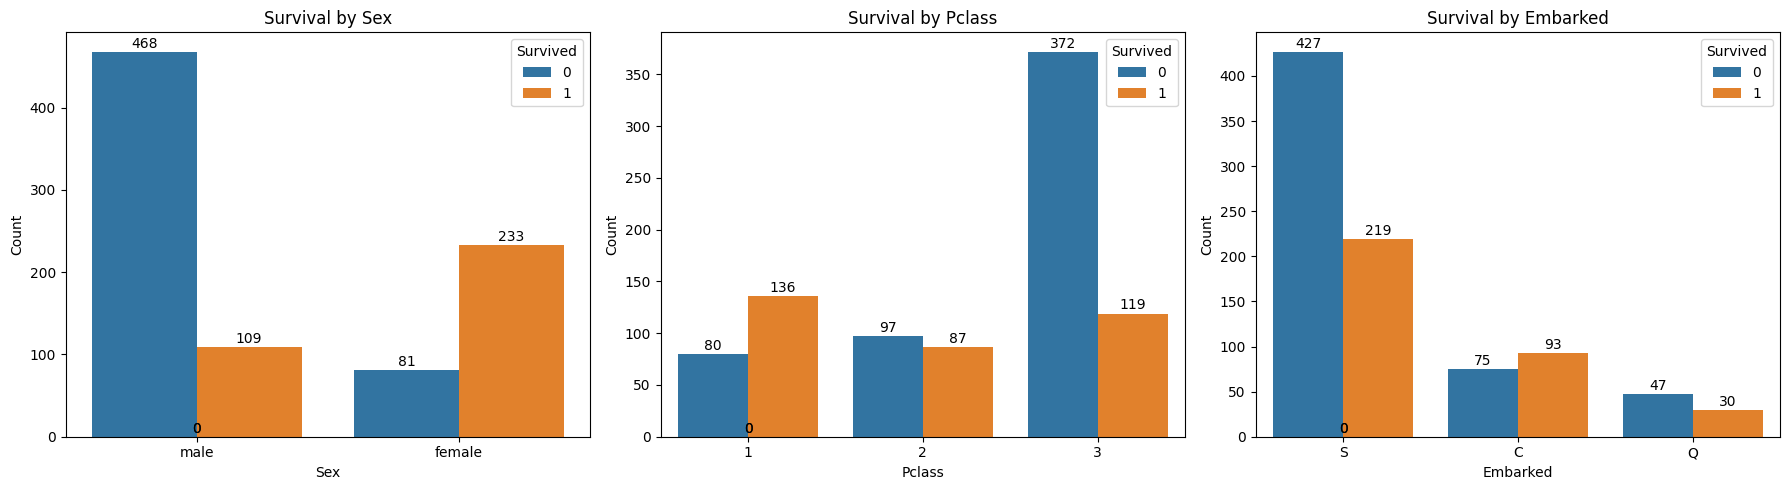

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=data, x='Sex', hue='Survived', ax=axes[0])
axes[0].set_title('Survival by Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')
annotate_bars(axes[0])

sns.countplot(data=data, x='Pclass', hue='Survived', ax=axes[1])
axes[1].set_title('Survival by Pclass')
axes[1].set_xlabel('Pclass')
axes[1].set_ylabel('Count')
annotate_bars(axes[1])

sns.countplot(data=data, x='Embarked', hue='Survived', ax=axes[2])
axes[2].set_title('Survival by Embarked')
axes[2].set_xlabel('Embarked')
axes[2].set_ylabel('Count')
annotate_bars(axes[2])

plt.tight_layout()
plt.show()

#### This show that:
- most of **Survived** are **Female**
- most of **not survived** are from **class 2**
- most of **not survived** are from **Embarked S**

### Distribution of Numeric Features

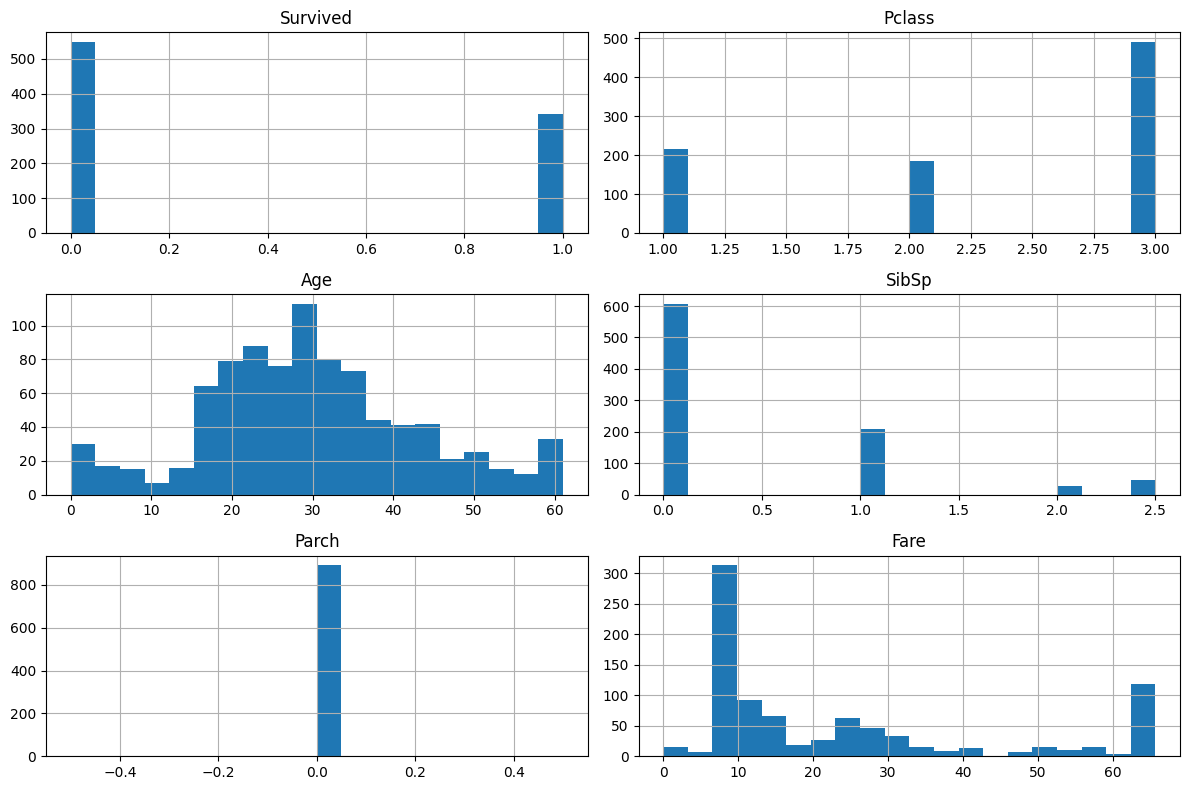

In [31]:
data[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

### Correlation Matrix

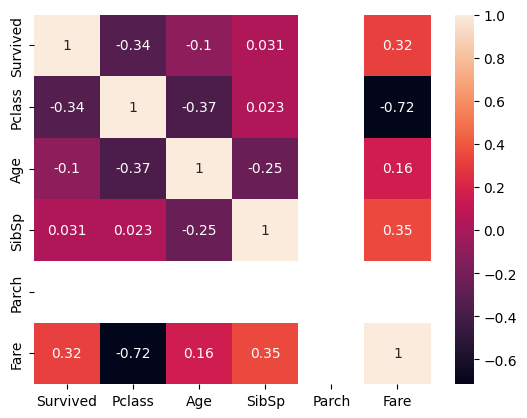

In [32]:
sns.heatmap(data[numeric_cols].corr(), annot=True)
plt.show()

## Feature Engineering

### Feature Selection

#### Remove **Parch** col because its **varience = 0**

In [33]:
data.drop(columns=['Parch'], inplace=True)

### Encoding

In [34]:
for col in categor_cols:
    print(data[col].value_counts())
    print('------------------------------------------\n')

Sex
male      577
female    314
Name: count, dtype: int64
------------------------------------------

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64
------------------------------------------



#### Encode **Sex** col with **Label Encoder** and **Embarked** with **one-how Encoder**

In [35]:
LE = LabelEncoder()
data['Sex'] = LE.fit_transform(data['Sex'])

In [36]:
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

In [37]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked_Q,Embarked_S
0,0,3,1,22,1.0,7.2500,False,True
1,1,1,0,38,1.0,65.6344,False,False
2,1,3,0,26,0.0,7.9250,False,True
3,1,1,0,35,1.0,53.1000,False,True
4,0,3,1,35,0.0,8.0500,False,True


### Splitting

In [38]:
X = data.drop(columns=['Survived'])
y = data['Survived']

In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [40]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(712, 7) (89, 7) (90, 7) (712,) (89,) (90,)


### Feature Scaling

In [41]:
SS = StandardScaler()
X_train_scaled = SS.fit_transform(X_train)
X_val_scaled = SS.transform(X_val)
X_test_scaled = SS.transform(X_test)

In [42]:
y_train.value_counts()

,count
Survived,
0,439
1,273


### Sampling

In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_samp, y_train_samp = smote.fit_resample(X_train_scaled, y_train)

# from imblearn.over_sampling import RandomOverSampler

# ROV = RandomOverSampler(random_state=42)
# X_train_samp, y_train_samp = ROV.fit_resample(X_train_scaled, y_train)

In [44]:
y_train_samp.value_counts()

,count
Survived,
1,439
0,439


## Modeling

### Logistic Regression

In [45]:
lr = LogisticRegression(random_state=42)
# lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
# lr.fit(X_train_samp, y_train_samp)

LogisticRegression(random_state=42)

In [46]:
y_pred_lr = lr.predict(X_val_scaled)
y_proba_lr = lr.predict_proba(X_val_scaled)[:,1]

In [47]:
print("Logistic Regression Report")
print(classification_report(y_val, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_val, y_proba_lr))

Logistic Regression Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        55
           1       0.84      0.76      0.80        34

    accuracy                           0.85        89
   macro avg       0.85      0.84      0.84        89
weighted avg       0.85      0.85      0.85        89

ROC-AUC: 0.8893048128342246


In [48]:
y_proba_train_lr = lr.predict_proba(X_train_scaled)[:,1]
print("ROC-AUC at training set:", roc_auc_score(y_train, y_proba_train_lr))

ROC-AUC at training set: 0.8684656270077682


### Decision Tree

In [49]:
# dt = DecisionTreeClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_scaled, y_train)
# dt.fit(X_train_samp, y_train_samp)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [50]:
y_pred_dt = dt.predict(X_val_scaled)
y_proba_dt = dt.predict_proba(X_val_scaled)[:,1]

In [51]:
print("Decision Tree Report")
print(classification_report(y_val, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_val, y_proba_dt))

Decision Tree Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        55
           1       0.79      0.76      0.78        34

    accuracy                           0.83        89
   macro avg       0.82      0.82      0.82        89
weighted avg       0.83      0.83      0.83        89

ROC-AUC: 0.8187165775401071


In [52]:
y_proba_train_dt = dt.predict_proba(X_train_scaled)[:,1]
print("ROC-AUC at training set:", roc_auc_score(y_train, y_proba_train_dt))

ROC-AUC at training set: 0.9995661134613298


### Random Forest (Bagging)

In [53]:
# rf = RandomForestClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
# rf.fit(X_train_samp, y_train_samp)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [54]:
y_pred_rf = rf.predict(X_val_scaled)
y_proba_rf = rf.predict_proba(X_val_scaled)[:,1]

In [55]:
print("Random Forest Report")
print(classification_report(y_val, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, y_proba_rf))

Random Forest Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        55
           1       0.81      0.76      0.79        34

    accuracy                           0.84        89
   macro avg       0.84      0.83      0.83        89
weighted avg       0.84      0.84      0.84        89

ROC-AUC: 0.8866310160427807


In [56]:
y_proba_train_rf = rf.predict_proba(X_train_scaled)[:,1]
print("ROC-AUC at training set:", roc_auc_score(y_train, y_proba_train_rf))

ROC-AUC at training set: 0.9995577694894322


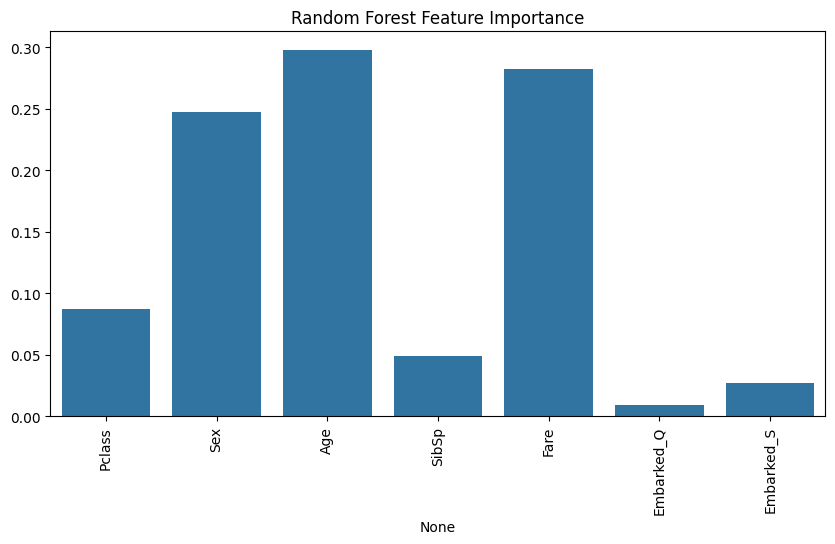

In [57]:
# Feature importance
plt.figure(figsize=(10,5))
sns.barplot(x=X_train.columns, y=rf.feature_importances_)
plt.xticks(rotation=90)
plt.title('Random Forest Feature Importance')
plt.show()

### XGBoost (Boosting)

In [58]:
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train_scaled, y_train)
# xgb_clf.fit(X_train_samp, y_train_samp)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [59]:
y_pred_xgb = xgb_clf.predict(X_val_scaled)
y_proba_xgb = xgb_clf.predict_proba(X_val_scaled)[:,1]

In [60]:
print("XGBoost Report")
print(classification_report(y_val, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_val, y_proba_xgb))

XGBoost Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        55
           1       0.84      0.76      0.80        34

    accuracy                           0.85        89
   macro avg       0.85      0.84      0.84        89
weighted avg       0.85      0.85      0.85        89

ROC-AUC: 0.8868983957219251


In [61]:
y_proba_train_xgb = xgb_clf.predict_proba(X_train_scaled)[:,1]
print("ROC-AUC at training set:", roc_auc_score(y_train, y_proba_train_xgb))

ROC-AUC at training set: 0.9894323595918129


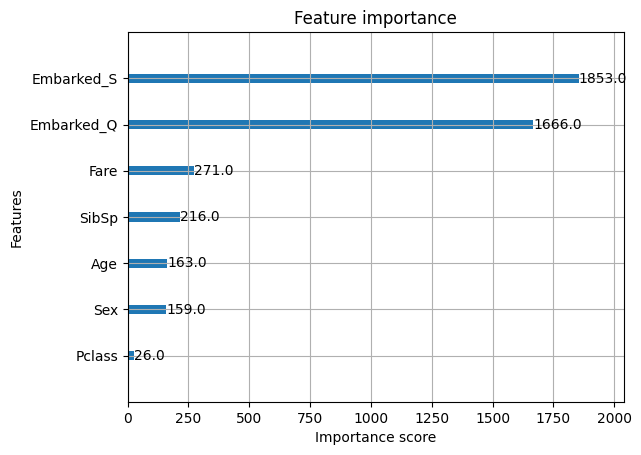

In [62]:
# Feature importance
# xgb.plot_importance(xgb_clf)
ax = xgb.plot_importance(xgb_clf, importance_type='weight', xlabel='Importance score', ylabel='Features', title='Feature importance', show_values=True)
ax.set_yticklabels(X_train.columns.tolist())
plt.show()

### Evaluation Curves (ROC / Precision-Recall)

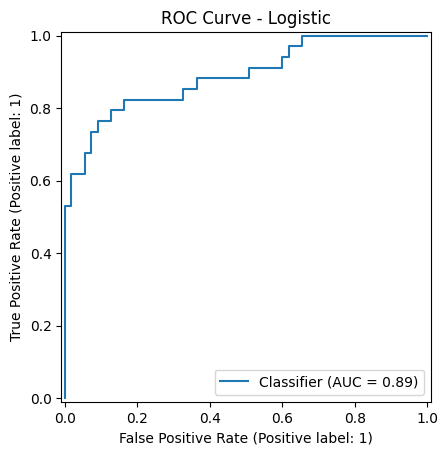

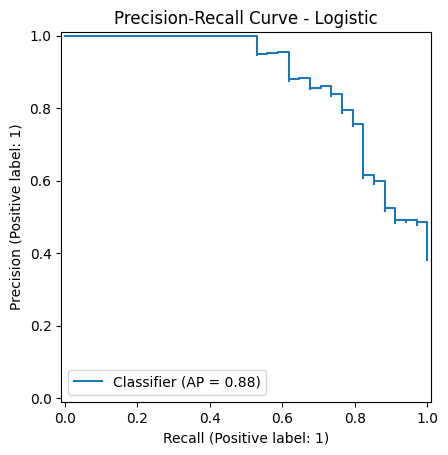

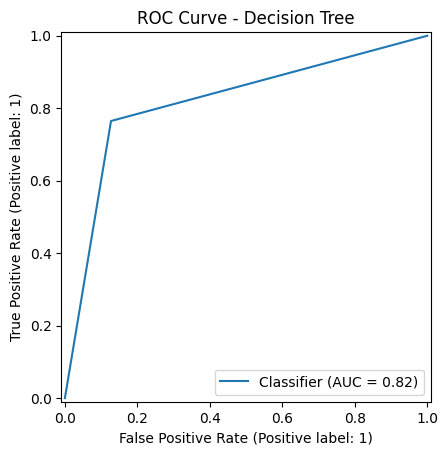

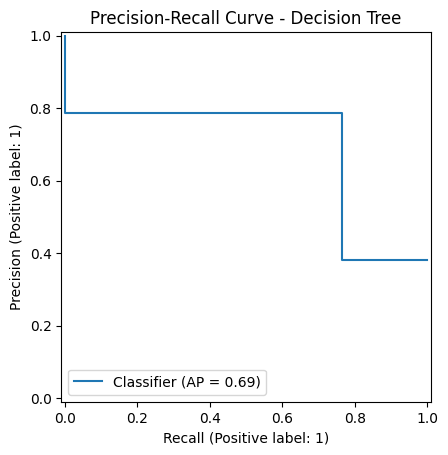

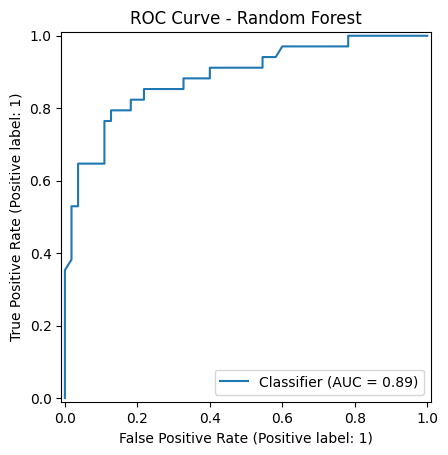

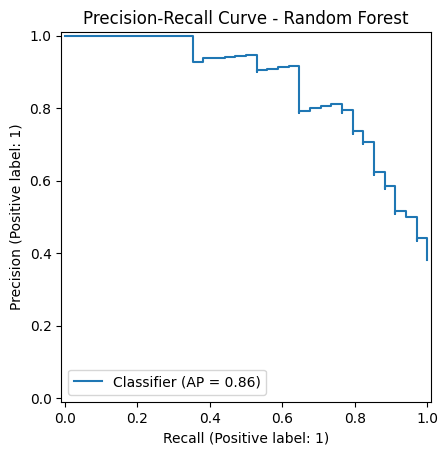

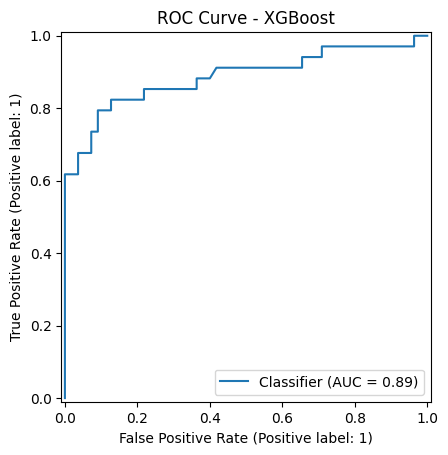

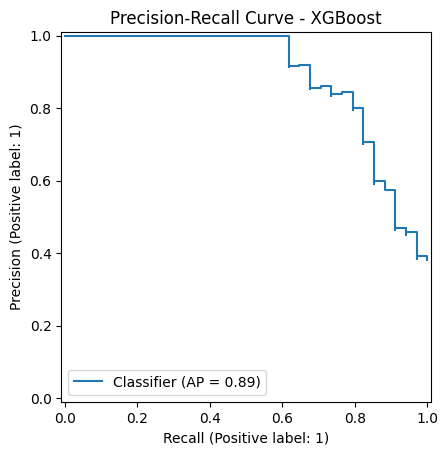

In [63]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

models = {'Logistic': (y_val, y_proba_lr),
          'Decision Tree': (y_val, y_proba_dt),
          'Random Forest': (y_val, y_proba_rf),
          'XGBoost': (y_val, y_proba_xgb)}

for name, (y_true, y_scores) in models.items():
    RocCurveDisplay.from_predictions(y_true, y_scores)
    plt.title(f'ROC Curve - {name}')
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_scores)
    plt.title(f'Precision-Recall Curve - {name}')
    plt.show()

### Hyperparameter Tuning

In [64]:
# Manual Hyperparameter Tuning for XGBoost

# Convert data to DMatrix format (needed for xgb.train)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

# Tuning Pass 1: Tune max_depth and learning_rate (already executed)
print("--- Tuning Pass 1: max_depth and learning_rate ---")

results_pass1 = []
max_depth_values_pass1 = [3, 4, 5, 6]
learning_rate_values_pass1 = [0.1, 0.05, 0.01]

for max_depth in max_depth_values_pass1:
    for learning_rate in learning_rate_values_pass1:
        # print(f"Training with max_depth={max_depth}, learning_rate={learning_rate}")
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'eta': learning_rate,
            'max_depth': max_depth,
            'seed': 42
        }

        num_rounds = 200

        bst = xgb.train(params,
                        dtrain,
                        num_boost_round=num_rounds,
                        verbose_eval=False
                       )

        y_proba_val = bst.predict(dval)
        roc_auc = roc_auc_score(y_val, y_proba_val)

        # print(f"  ROC-AUC on validation set: {roc_auc:.4f}")
        results_pass1.append({'max_depth': max_depth, 'learning_rate': learning_rate, 'roc_auc_val': roc_auc})

results_df_pass1 = pd.DataFrame(results_pass1)
print("\nPass 1 Results:")
display(results_df_pass1.pivot(index='max_depth', columns='learning_rate', values='roc_auc_val'))


# Tuning Pass 2: Tune subsample and colsample_bytree with Early Stopping
print("\n--- Tuning Pass 2: subsample and colsample_bytree with Early Stopping ---")

results_pass2 = []
# Based on Pass 1, choosing a good combination to start with for further tuning
# Let's use max_depth=5 and learning_rate=0.01 based on Pass 1 results
best_max_depth_pass1 = 5
best_learning_rate_pass1 = 0.01

subsample_values = [0.7, 0.8, 0.9, 1.0]
colsample_bytree_values = [0.7, 0.8, 0.9, 1.0]


for subsample in subsample_values:
    for colsample_bytree in colsample_bytree_values:
        print(f"Training with subsample={subsample}, colsample_bytree={colsample_bytree}")
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss', # Or 'auc' if preferred for early stopping
            'eta': best_learning_rate_pass1,
            'max_depth': best_max_depth_pass1,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'seed': 42
        }

        # Increase num_boost_round to make early stopping more likely
        num_boost_round_pass2 = 2000

        bst_tuned = xgb.train(params,
                             dtrain,
                             num_boost_round=num_boost_round_pass2,
                             evals=[(dval, 'eval')], # Use validation set for early stopping
                             early_stopping_rounds=50, # Stop if validation score doesn't improve for 50 rounds
                             verbose_eval=False
                            )

        # Evaluate on validation set using the best iteration found by early stopping
        # best_iteration is an attribute of the trained booster when using early_stopping_rounds in xgb.train
        best_iteration = bst_tuned.best_iteration + 1


        y_proba_val_tuned = bst_tuned.predict(dval, iteration_range=(0, best_iteration))
        roc_auc_tuned = roc_auc_score(y_val, y_proba_val_tuned)

        print(f"  ROC-AUC on validation set (with early stopping): {roc_auc_tuned:.4f}")
        results_pass2.append({'subsample': subsample, 'colsample_bytree': colsample_bytree, 'roc_auc_val': roc_auc_tuned, 'best_iteration': best_iteration})

# Display results from Pass 2
results_df_pass2 = pd.DataFrame(results_pass2)
print("\nPass 2 Results:")
display(results_df_pass2.pivot_table(index='subsample', columns='colsample_bytree', values='roc_auc_val'))

# Based on these results, we will decide on the best values for subsample and colsample_bytree and best_iteration
# and potentially proceed to the next tuning pass or finalize the model.

--- Tuning Pass 1: max_depth and learning_rate ---

Pass 1 Results:


learning_rate,0.01,0.05,0.10
max_depth,,,
3,0.863636,0.854813,0.855348
4,0.878877,0.874064,0.865508
5,0.887968,0.883690,0.878877
6,0.879947,0.886898,0.890642



--- Tuning Pass 2: subsample and colsample_bytree with Early Stopping ---
Training with subsample=0.7, colsample_bytree=0.7
  ROC-AUC on validation set (with early stopping): 0.8896
Training with subsample=0.7, colsample_bytree=0.8
  ROC-AUC on validation set (with early stopping): 0.8901
Training with subsample=0.7, colsample_bytree=0.9
  ROC-AUC on validation set (with early stopping): 0.8928
Training with subsample=0.7, colsample_bytree=1.0
  ROC-AUC on validation set (with early stopping): 0.8917
Training with subsample=0.8, colsample_bytree=0.7
  ROC-AUC on validation set (with early stopping): 0.8832
Training with subsample=0.8, colsample_bytree=0.8
  ROC-AUC on validation set (with early stopping): 0.8832
Training with subsample=0.8, colsample_bytree=0.9
  ROC-AUC on validation set (with early stopping): 0.8890
Training with subsample=0.8, colsample_bytree=1.0
  ROC-AUC on validation set (with early stopping): 0.8901
Training with subsample=0.9, colsample_bytree=0.7
  ROC-AUC o

colsample_bytree,0.7,0.8,0.9,1.0
subsample,,,,
0.7,0.889572,0.890107,0.892781,0.891711
0.8,0.883155,0.883155,0.889037,0.890107
0.9,0.885294,0.884225,0.885829,0.888503
1.0,0.885829,0.881016,0.885294,0.891176


### Model Saving

### Train and Save Best XGBoost Model

In [65]:
import joblib

# Best hyperparameters found from tuning Pass 2
best_xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01, # Best learning_rate from Pass 1
    'max_depth': 5, # Best max_depth from Pass 1
    'subsample': 0.7, # Best subsample from Pass 2
    'colsample_bytree': 0.9, # Best colsample_bytree from Pass 2
    'seed': 42
}

# Best number of boosting rounds from early stopping in Pass 2
best_num_boost_rounds = 527 # Based on Pass 2 results for subsample=0.7, colsample_bytree=0.9

# Train the final XGBoost model on the entire scaled training data
final_xgb_model = xgb.train(best_xgb_params,
                          xgb.DMatrix(X_train_scaled, label=y_train),
                          num_boost_round=best_num_boost_rounds,
                          verbose_eval=False
                         )

# Save the final model and the best number of boosting rounds
joblib.dump({'model': final_xgb_model, 'best_num_boost_rounds': best_num_boost_rounds}, 'best_xgboost_model.pkl')

print(f"Best XGBoost model trained with {best_num_boost_rounds} boosting rounds and saved as 'best_xgboost_model.pkl'")

Best XGBoost model trained with 527 boosting rounds and saved as 'best_xgboost_model_with_rounds.pkl' along with best_num_boost_rounds


### Random Forest Manual Tuning - Pass 1: `n_estimators` and `max_depth`

In [66]:
# Tuning Pass 1: Tune n_estimators and max_depth
print("--- Random Forest Tuning Pass 1: n_estimators and max_depth ---")

results_rf_pass1 = []
n_estimators_values = [100, 200, 300, 400] # Number of trees
max_depth_values = [3, 5, 7, 10, None] # Max depth of trees (None means unlimited)

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        print(f"Training with n_estimators={n_estimators}, max_depth={max_depth}")

        # Initialize and train the Random Forest model
        rf_tuned = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        random_state=42,
                                        class_weight='balanced', # Keep class weight for handling imbalance
                                        n_jobs=-1 # Use all available cores
                                       )
        rf_tuned.fit(X_train_scaled, y_train) # Fit on scaled training data

        # Evaluate on validation set
        y_proba_val_rf = rf_tuned.predict_proba(X_val_scaled)[:, 1]
        roc_auc_rf = roc_auc_score(y_val, y_proba_val_rf)

        print(f"  ROC-AUC on validation set: {roc_auc_rf:.4f}")
        results_rf_pass1.append({'n_estimators': n_estimators, 'max_depth': max_depth, 'roc_auc_val': roc_auc_rf})

# Display results from Pass 1
results_df_rf_pass1 = pd.DataFrame(results_rf_pass1)
print("\nRandom Forest Pass 1 Results:")
display(results_df_rf_pass1.pivot(index='n_estimators', columns='max_depth', values='roc_auc_val'))

# Based on these results, we will decide on the best values for n_estimators and max_depth
# and proceed to the next tuning pass focusing on other hyperparameters.

--- Random Forest Tuning Pass 1: n_estimators and max_depth ---
Training with n_estimators=100, max_depth=3
  ROC-AUC on validation set: 0.8698
Training with n_estimators=100, max_depth=5
  ROC-AUC on validation set: 0.8821
Training with n_estimators=100, max_depth=7
  ROC-AUC on validation set: 0.8858
Training with n_estimators=100, max_depth=10
  ROC-AUC on validation set: 0.8743
Training with n_estimators=100, max_depth=None
  ROC-AUC on validation set: 0.8856
Training with n_estimators=200, max_depth=3
  ROC-AUC on validation set: 0.8725
Training with n_estimators=200, max_depth=5
  ROC-AUC on validation set: 0.8824
Training with n_estimators=200, max_depth=7
  ROC-AUC on validation set: 0.8877
Training with n_estimators=200, max_depth=10
  ROC-AUC on validation set: 0.8797
Training with n_estimators=200, max_depth=None
  ROC-AUC on validation set: 0.8866
Training with n_estimators=300, max_depth=3
  ROC-AUC on validation set: 0.8725
Training with n_estimators=300, max_depth=5
  RO

max_depth,NaN,3.0,5.0,7.0,10.0
n_estimators,,,,,
100,0.885561,0.869786,0.882086,0.885829,0.874332
200,0.886631,0.872460,0.882353,0.887701,0.879679
300,0.882353,0.872460,0.883422,0.889840,0.882353
400,0.883957,0.872460,0.882888,0.889305,0.879144


### Random Forest Manual Tuning - Pass 2: `min_samples_split` and `min_samples_leaf`

In [67]:
# Based on Random Forest Pass 1 results
best_n_estimators_pass1 = 300
best_max_depth_pass1 = 7

# Tuning Pass 2: Tune min_samples_split and min_samples_leaf
print("--- Random Forest Tuning Pass 2: min_samples_split and min_samples_leaf ---")

results_rf_pass2 = []
min_samples_split_values = [2, 5, 10, 20]
min_samples_leaf_values = [1, 2, 4, 8]

for min_samples_split in min_samples_split_values:
    for min_samples_leaf in min_samples_leaf_values:
        print(f"Training with min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")

        # Initialize and train the Random Forest model with best params from Pass 1
        rf_tuned = RandomForestClassifier(n_estimators=best_n_estimators_pass1,
                                        max_depth=best_max_depth_pass1,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=42,
                                        class_weight='balanced', # Keep class weight
                                        n_jobs=-1 # Use all available cores
                                       )
        rf_tuned.fit(X_train_scaled, y_train) # Fit on scaled training data

        # Evaluate on validation set
        y_proba_val_rf = rf_tuned.predict_proba(X_val_scaled)[:, 1]
        roc_auc_rf = roc_auc_score(y_val, y_proba_val_rf)

        print(f"  ROC-AUC on validation set: {roc_auc_rf:.4f}")
        results_rf_pass2.append({'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'roc_auc_val': roc_auc_rf})

# Display results from Pass 2
results_df_rf_pass2 = pd.DataFrame(results_rf_pass2)
print("\nRandom Forest Pass 2 Results:")
display(results_df_rf_pass2.pivot(index='min_samples_split', columns='min_samples_leaf', values='roc_auc_val'))

# Based on these results, we will decide on the best values for min_samples_split and min_samples_leaf
# and potentially proceed to a third tuning pass or finalize the model.

--- Random Forest Tuning Pass 2: min_samples_split and min_samples_leaf ---
Training with min_samples_split=2, min_samples_leaf=1
  ROC-AUC on validation set: 0.8898
Training with min_samples_split=2, min_samples_leaf=2
  ROC-AUC on validation set: 0.8968
Training with min_samples_split=2, min_samples_leaf=4
  ROC-AUC on validation set: 0.8920
Training with min_samples_split=2, min_samples_leaf=8
  ROC-AUC on validation set: 0.8775
Training with min_samples_split=5, min_samples_leaf=1
  ROC-AUC on validation set: 0.8925
Training with min_samples_split=5, min_samples_leaf=2
  ROC-AUC on validation set: 0.8925
Training with min_samples_split=5, min_samples_leaf=4
  ROC-AUC on validation set: 0.8920
Training with min_samples_split=5, min_samples_leaf=8
  ROC-AUC on validation set: 0.8775
Training with min_samples_split=10, min_samples_leaf=1
  ROC-AUC on validation set: 0.8914
Training with min_samples_split=10, min_samples_leaf=2
  ROC-AUC on validation set: 0.8882
Training with min_samp

min_samples_leaf,1,2,4,8
min_samples_split,,,,
2,0.889840,0.896791,0.891979,0.877540
5,0.892513,0.892513,0.891979,0.877540
10,0.891444,0.888235,0.888770,0.877540
20,0.886631,0.888770,0.883957,0.882353


### Train and Save Best Random Forest Model

In [68]:
# Best hyperparameters found from Random Forest tuning Pass 1 and Pass 2
best_rf_params = {
    'n_estimators': 300,
    'max_depth': 7,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'random_state': 42,
    'class_weight': 'balanced',
    'n_jobs': -1
}

# Train the final Random Forest model on the entire scaled training data
final_rf_model = RandomForestClassifier(**best_rf_params)
final_rf_model.fit(X_train_scaled, y_train)

# Save the final model
joblib.dump(final_rf_model, 'best_random_forest_model.pkl')

print("Best Random Forest model trained and saved as 'best_random_forest_model.pkl'")

Best Random Forest model trained and saved as 'best_random_forest_model.pkl'


## Final Evaluation on Test Set

In [69]:
import joblib
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd # Ensure pandas is imported

# Load the best saved XGBoost model and best_num_boost_rounds
xgb_model_data = joblib.load('best_xgboost_model_with_rounds.pkl')
best_xgb_model = xgb_model_data['model']
best_num_boost_rounds_loaded = xgb_model_data['best_num_boost_rounds']

# Load the best saved Random Forest model
best_rf_model = joblib.load('best_random_forest_model.pkl')

# Convert test data to DMatrix for XGBoost prediction
dtest = xgb.DMatrix(X_test_scaled)

# Make predictions on the test set
# For XGBoost, use the predict method on the DMatrix with the loaded best_num_boost_rounds
y_pred_proba_xgb_test = best_xgb_model.predict(dtest, iteration_range=(0, best_num_boost_rounds_loaded))
y_pred_xgb_test = (y_pred_proba_xgb_test > 0.5).astype(int) # Convert probabilities to binary predictions

# For Random Forest, use the predict_proba method
y_pred_proba_rf_test = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_rf_test = best_rf_model.predict(X_test_scaled)

# The variables y_test, y_pred_xgb_test, y_pred_proba_xgb_test, y_pred_rf_test, and y_pred_proba_rf_test are now available for the next cell.

In [70]:
from sklearn.metrics import roc_auc_score, classification_report

# Evaluate XGBoost on the test set
print("--- Best Tuned XGBoost Model Evaluation on Test Set ---")
print(classification_report(y_test, y_pred_xgb_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb_test))

print("\n") # Add a newline for separation

# Evaluate Random Forest on the test set
print("--- Best Tuned Random Forest Model Evaluation on Test Set ---")
print(classification_report(y_test, y_pred_rf_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf_test))

# You can add evaluation for other models here if you saved them or want to re-evaluate
# Example for Logistic Regression (assuming lr model object is still available):
# print("\n--- Logistic Regression Evaluation on Test Set ---")
# y_pred_lr_test = lr.predict(X_test_scaled)
# y_proba_lr_test = lr.predict_proba(X_test_scaled)[:, 1]
# print(classification_report(y_test, y_pred_lr_test))
# print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr_test))

--- Best Tuned XGBoost Model Evaluation on Test Set ---
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        55
           1       0.77      0.69      0.73        35

    accuracy                           0.80        90
   macro avg       0.79      0.78      0.78        90
weighted avg       0.80      0.80      0.80        90

ROC-AUC: 0.82


--- Best Tuned Random Forest Model Evaluation on Test Set ---
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        55
           1       0.73      0.69      0.71        35

    accuracy                           0.78        90
   macro avg       0.77      0.76      0.76        90
weighted avg       0.78      0.78      0.78        90

ROC-AUC: 0.8184415584415584
